<a href="https://colab.research.google.com/github/MahaYounsi/malaria-cell-classification-cnn/blob/main/CNN_Malaria_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projet de classification d’images d’hématies**

## I) Manipulation de la Donnée

### 1) Télécharger les données fournies

In [8]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
zip_path = "/content/malaria_hematie_dataset.zip"
extract_path = "/content/malaria_dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

DATASET_ROOT = "/content/malaria_dataset/malaria_hematie_dataset"
print(os.listdir(DATASET_ROOT))

['parasitized', 'uninfected']


### 2) Charger les données

In [14]:
DATASET_ROOT = "/content/malaria_dataset/malaria_hematie_dataset"
data = []
for cls in ['parasitized', 'uninfected']:
    path = os.path.join(DATASET_ROOT, cls)
    for f in os.listdir(path):
        if f.endswith(('.png', '.jpg')): data.append([os.path.join(path, f), cls])

df = pd.DataFrame(data, columns=['path', 'label'])
df['label_num'] = LabelEncoder().fit_transform(df['label'])

### 4) Encoder les labels

In [15]:
# 4) Séparation des données (Train, Val, Test)
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label_num'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label_num'], random_state=42)

### 3, 5) Normalisation (rescale) et Augmentation

In [16]:
class MalariaDataSequence(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size=32, augment=False):
        self.df = df
        self.batch_size = batch_size
        self.augment = augment
        self.datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255, rotation_range=15, horizontal_flip=True) if augment else tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

    def __len__(self): return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, idx):
        batch = self.df[idx*self.batch_size : (idx+1)*self.batch_size]
        imgs = [np.array(Image.open(p).convert("RGB").resize((124,124))) for p in batch['path']]
        x = np.array(imgs).astype('float32')
        y = batch['label_num'].values
        return next(self.datagen.flow(x, y, batch_size=len(batch), shuffle=False))

train_gen = MalariaDataSequence(train_df, augment=True)
val_gen = MalariaDataSequence(val_df)
test_gen = MalariaDataSequence(test_df)

### 6) Affichage des images augmentées

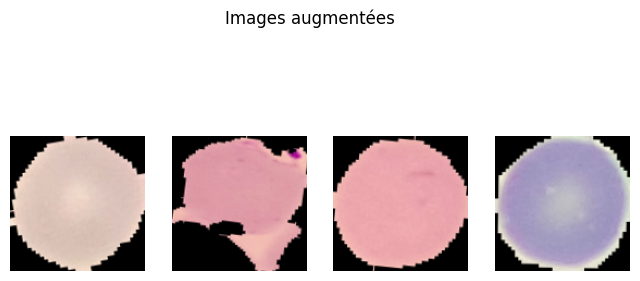

In [18]:
x_aug, _ = train_gen[0]
plt.figure(figsize=(8,4))
for i in range(4): plt.subplot(1,4,i+1); plt.imshow(x_aug[i]); plt.axis('off')
plt.suptitle("Images augmentées"); plt.show()

## II) Entraînement de 3 Modèles

### 1) Implémentation de 2 Callbacks

In [20]:
from tensorflow.keras import callbacks

# Surveillance de la perte de validation (val_loss)
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Réduction du taux d'apprentissage en cas de plateau de performance
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

my_callbacks = [early_stopping, reduce_lr]

### 2) Implémentation de 3 CNN pour la Labelisation à l'aide de Keras

A. Modèle from scratch avec Sequential

In [21]:
from tensorflow.keras import layers, models, Sequential

model_scratch = Sequential([
    layers.Input(shape=(124, 124, 3)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5), # Dropout pour éviter le surapprentissage
    layers.Dense(1, activation='sigmoid') # Sigmoid pour classification binaire
])

B. Fine-tuning du VGG16 pré-entraîné

In [22]:
from tensorflow.keras.applications import VGG16

vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(124, 124, 3))
vgg_base.trainable = False # On gèle les poids pré-entraînés

model_vgg = Sequential([
    vgg_base,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


C. Fine-tuning du ResNet50 pré-entraîné

In [23]:
from tensorflow.keras.applications import ResNet50

res_base = ResNet50(weights='imagenet', include_top=False, input_shape=(124, 124, 3))
res_base.trainable = False # Gel de l'encodeur

model_resnet = Sequential([
    res_base,
    layers.GlobalAveragePooling2D(), # Utilisation de pooling global pour ResNet
    layers.Dense(1, activation='sigmoid')
])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### 3,4) Entraînement des 3 modèles et sauvegarde

In [25]:
# Dictionnaire pour automatiser l'entraînement des 3 modèles
models_dict = {
    "Scratch": model_scratch,
    "VGG16": model_vgg,
    "ResNet50": model_resnet
}

# Boucle d'entraînement
for name, model in models_dict.items():
    print(f"\n" + "="*30)
    print(f"Début de l'entraînement : {name}")
    print("="*30)

    # Compilation (nécessaire avant le fit)
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Entraînement avec les callbacks implémentés
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=10, # Ajustable selon vos ressources
        callbacks=my_callbacks, # EarlyStopping et ReduceLROnPlateau
        verbose=1
    )

    # 4) Sauvegarder les poids du modèle
    weight_filename = f"weights_{name.lower()}.weights.h5"
    model.save_weights(weight_filename)
    print(f"Poids sauvegardés : {weight_filename}")


Début de l'entraînement : Scratch
Epoch 1/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 114s 184ms/step - accuracy: 0.9435 - loss: 0.1737 - val_accuracy: 0.9504 - val_loss: 0.1660 - learning_rate: 0.0010
Epoch 2/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 107s 177ms/step - accuracy: 0.9506 - loss: 0.1545 - val_accuracy: 0.9492 - val_loss: 0.1632 - learning_rate: 0.0010
Epoch 3/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 107s 178ms/step - accuracy: 0.9524 - loss: 0.1479 - val_accuracy: 0.9412 - val_loss: 0.1902 - learning_rate: 0.0010
Epoch 4/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 107s 178ms/step - accuracy: 0.9537 - loss: 0.1420 - val_accuracy: 0.9519 - val_loss: 0.1660 - learning_rate: 0.0010
Epoch 5/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9515 - loss: 0.1441
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
603/603 ━━━━━━━━━━━━━━━━━━━━ 107s 177ms/step - accuracy: 0.9515 - loss: 0.1441 - val_accuracy: 0.9453 - val_loss: 0.1952 - learning_rate: 0.0010
Epoch 6/10
603/603 ━━━━━━━━━━━━━

# Interprétation des résultats :
AUC proche de 1.0 : Le modèle est excellent pour différencier les hématies saines des infectées.

VGG16 vs ResNet50 : En général, les modèles pré-entraînés (Fine-tuning) obtiennent une meilleure AUC que le modèle "from scratch" car ils possèdent déjà une expertise en extraction de formes.

Sensibilité (Recall) : C'est la métrique la plus importante ici. Un faux négatif (dire qu'une cellule est saine alors qu'elle est infectée) est très grave en médecine.

## III) Test des Modèles

### 1) Calculer la Matrice de Confusion
Nous calculons ici l'accuracy, la précision, le recall (sensibilité), le f1-score et la spécificité.

In [29]:
# Utilisation des noms de variables définis dans la partie II
models_to_test = {
    "Scratch": model_scratch,
    "VGG16": model_vgg,
    "ResNet50": model_resnet
}

for name, model in models_to_test.items():
    print(f"\n--- Matrice de Confusion : {name} ---")

    # Prédictions sur le générateur de test
    y_pred_prob = model.predict(test_gen)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Récupération des vrais labels
    y_true = test_df['label_num'].values

    # Calcul de la matrice
    cm = confusion_matrix(y_true, y_pred)
    print(cm)


--- Matrice de Confusion : Scratch ---
130/130 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step
[[1964  103]
 [  65 2002]]

--- Matrice de Confusion : VGG16 ---
130/130 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step
[[1943  124]
 [  87 1980]]

--- Matrice de Confusion : ResNet50 ---
130/130 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step
[[1207  860]
 [ 486 1581]]


### 2) Calculer les métriques de performance
Le graphique ROC permet de visualiser la performance globale, et l'AUC la résume en un seul chiffre.

In [30]:
for name, model in models_to_test.items():
    y_pred_prob = model.predict(test_gen)
    y_pred = (y_pred_prob > 0.5).astype(int)
    y_true = test_df['label_num'].values

    # Rapport global (Accuracy, Precision, Recall, F1)
    print(f"\n--- Métriques : {name} ---")
    print(classification_report(y_true, y_pred, target_names=['Parasité', 'Sain']))

    # Calcul de la Spécificité : TN / (TN + FP)
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificite = tn / (tn + fp)
    print(f"Spécificité : {specificite:.2f}")

130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step

--- Métriques : Scratch ---
              precision    recall  f1-score   support

    Parasité       0.97      0.95      0.96      2067
        Sain       0.95      0.97      0.96      2067

    accuracy                           0.96      4134
   macro avg       0.96      0.96      0.96      4134
weighted avg       0.96      0.96      0.96      4134

Spécificité : 0.95
130/130 ━━━━━━━━━━━━━━━━━━━━ 15s 117ms/step

--- Métriques : VGG16 ---
              precision    recall  f1-score   support

    Parasité       0.96      0.94      0.95      2067
        Sain       0.94      0.96      0.95      2067

    accuracy                           0.95      4134
   macro avg       0.95      0.95      0.95      4134
weighted avg       0.95      0.95      0.95      4134

Spécificité : 0.94
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step

--- Métriques : ResNet50 ---
              precision    recall  f1-score   support

    Parasité       0.71      0.58     

### 3) Afficher le graphique ROC et calculer l’AUC de chacun des 3 modèles.

130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step


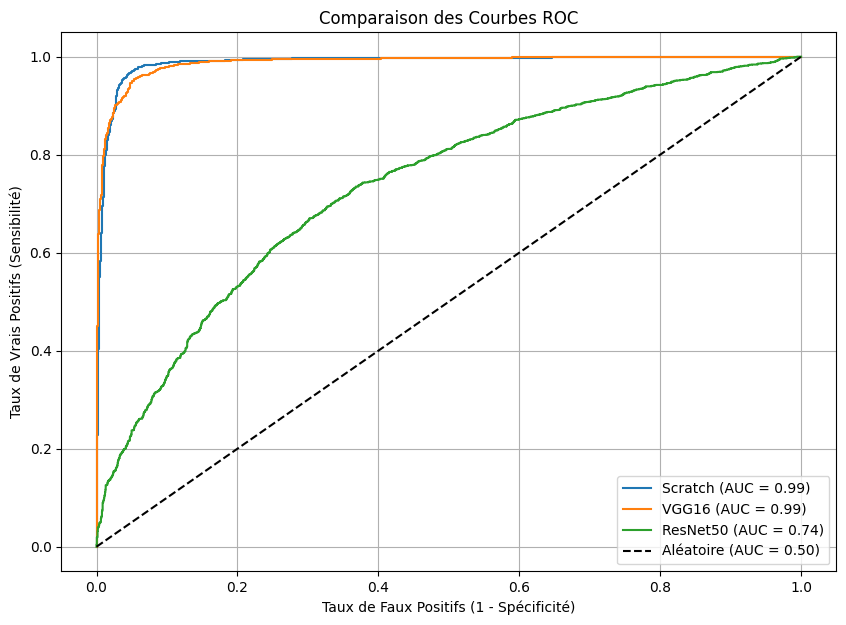

In [31]:
plt.figure(figsize=(10, 7))

for name, model in models_to_test.items():
    y_pred_prob = model.predict(test_gen)
    y_true = test_df['label_num'].values

    # Calcul de la courbe ROC et de l'AUC
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    auc_score = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Aléatoire (AUC = 0.50)')
plt.xlabel('Taux de Faux Positifs (1 - Spécificité)')
plt.ylabel('Taux de Vrais Positifs (Sensibilité)')
plt.title('Comparaison des Courbes ROC')
plt.legend()
plt.grid(True)
plt.show()

# Interprétation des résultats
Interprétation de l'AUC : Plus l'AUC est proche de 1, plus le modèle est performant pour séparer les hématies parasitées des saines.

Sensibilité vs Spécificité : Dans le diagnostic du paludisme, la sensibilité (Recall) est prioritaire car on ne veut surtout pas manquer un patient malade.